**Einlesen der Daten**

In [45]:
import pandas as pd

df = pd.read_csv("trainingsdaten_ohne_vibration.csv", encoding = "ISO-8859-1")
df_test = pd.read_csv("testdaten_mit_vibration.csv", encoding = "ISO-8859-1")

**Trainingsdaten anschauen**

In [46]:
df.head()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
0,7.417,2.098,0,0,3214
1,0.726,0.402,0,0,3339
2,6.061,2.092,0,0,3167
3,0.716,0.298,0,0,3261
4,0.638,0.578,0,0,3011


**Testdaten anschauen**

In [16]:
df_test.head()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime,VibrationMotorOn
0,36.285,12.502,0,0,3230,1
1,71.899,24.918,0,0,3199,1
2,543.236,474.136,0,0,4041,1
3,44.625,15.188,0,0,5055,1
4,34.323,11.074,0,0,3089,1


**Deskriptive Statistik (Trainingsdaten)**

In [17]:
df.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
count,2090.000000,2090.000000,2090.0,2090.0,2090.000000
mean,1.159642,0.519354,0.0,0.0,4130.505742
std,1.760196,0.676685,0.0,0.0,773.941131
min,0.000000,0.000000,0.0,0.0,3011.000000
25%,0.320000,0.168000,0.0,0.0,3245.000000
50%,0.471000,0.254000,0.0,0.0,4462.000000
75%,0.830250,0.416000,0.0,0.0,4837.000000
max,18.418000,7.834000,0.0,0.0,6927.000000


**Deskriptive Statistik (Testdaten)**

In [20]:
df_test.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime,VibrationMotorOn
count,187.000000,187.000000,187.0,187.0,187.000000,187.000000
mean,70.186679,32.865059,0.0,0.0,4148.048128,0.946524
std,123.702463,87.268628,0.0,0.0,1364.414429,0.225585
min,0.061000,0.042000,0.0,0.0,2481.000000,0.000000
25%,29.116000,9.063000,0.0,0.0,3050.500000,1.000000
50%,38.549000,12.502000,0.0,0.0,3760.000000,1.000000
75%,51.010500,17.995000,0.0,0.0,4704.000000,1.000000
max,580.684000,496.094000,0.0,0.0,8815.000000,1.000000


**Visualize data**

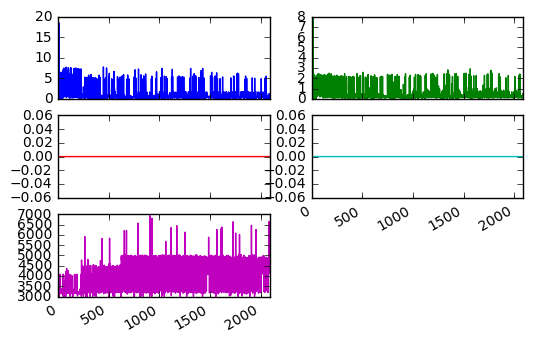

In [21]:
import matplotlib.pyplot as plt

df.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

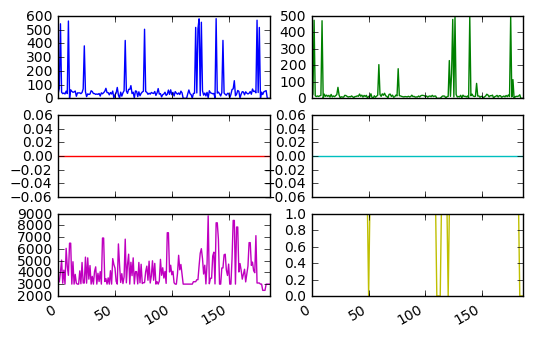

In [22]:
df_test.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

**Datenvorverarbeitung**

In [23]:
# 2 Spalten enthalten keine Information -> Löschen
df = df.drop(['NumberOverload', 'NumberUnderloads'], 1)
df_test = df_test.drop(['NumberOverload', 'NumberUnderloads'], 1)

**Test- und Trainingsdaten festlegen**

In [24]:
X_train = df
X_test = df_test[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].copy()
y_test = df_test[['VibrationMotorOn']].copy()

**Modell trainieren**

In [26]:
from sklearn.ensemble import IsolationForest

# Modell fitten
clf = IsolationForest()
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

new_column = pd.DataFrame(columns = ["Anomaly"])
# Vorhersage des Modells
for k in range(len(X_test)):
    temp = clf.predict([[X_test["AmplitudeBandWidth"][k], X_test["AmplitudeMean"][k], X_test["StabilizationTime"][k]]])[0]
    new_column = new_column.append({"Anomaly": temp}, ignore_index = True)

# Vorhersage des Modells auf 1/0 recodieren
new_column['Anomaly'] = new_column['Anomaly'].map( {1: 0, -1: 1} )

**Metriken ausgeben**

In [31]:
from sklearn import metrics

print("Accuracy: ", metrics.accuracy_score(y_test, new_column))  
print("Precision: ", metrics.precision_score(y_test, new_column))  
print("Recall: ", metrics.recall_score(y_test, new_column))  
print("F1: ", metrics.f1_score(y_test, new_column))  
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, new_column))  

('Accuracy: ', 0.96256684491978606)
('Precision: ', 0.97222222222222221)
('Recall: ', 0.98870056497175141)
('F1: ', 0.98039215686274506)
Confusion Matrix:
[[  5   5]
 [  2 175]]


**Daten zusammenführen für Visualisierung**

In [42]:
complete_data = X_test.copy()
complete_data['VibrationMotorOn'] = y_test['VibrationMotorOn']
complete_data['Anomaly'] = new_column.values

**Visualisieren der Vorhersagen**

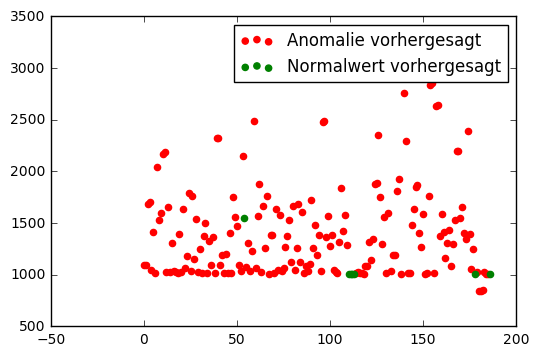

In [43]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
a = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['Anomaly'] == 1] # Anomalie vorhergesagt
n = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['Anomaly'] == 0] # Normalwert vorhergesagt

ax.scatter(a.index,a.mean(axis=1), color='red', label='Anomalie vorhergesagt')
ax.scatter(n.index,n.mean(axis=1), color='green', label='Normalwert vorhergesagt')

plt.legend()
plt.show()

**Visualisieren der tatsächlichen Anomalien**

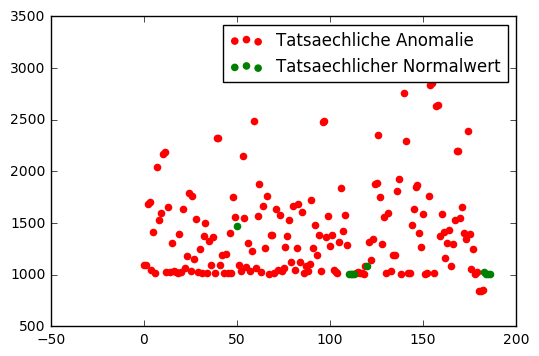

In [44]:
fig, ax = plt.subplots()
a = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['VibrationMotorOn'] == 1] #true anomaly
n = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['VibrationMotorOn'] == 0] #true normal

ax.scatter(a.index,a.mean(axis=1), color='red', label='Tatsaechliche Anomalie')
ax.scatter(n.index,n.mean(axis=1), color='green', label='Tatsaechlicher Normalwert')

plt.legend()
plt.show()